# Model Evaluation

## Train model for churn prediction

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer 
from sklearn.linear_model import LogisticRegression

In [3]:
# data oading and preparation
df = pd.read_csv('../data/customer_churn_data.csv')

In [25]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
categorical_columns = list(df.dtypes[df.dtypes == 'object' ].index)
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [54]:
#categorical_columns

In [49]:
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors = 'coerce')
#df['totalcharges'].isnull().sum()
df['totalcharges'] = df['totalcharges'].fillna(0)#
#df['totalcharges'].isnull().sum()
df.churn = (df.churn == 'yes').astype('int') #  = df.churn

In [69]:
# split df in full_train and test and full train in train and val
df_full_train, df_test = train_test_split(df, test_size= 0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size= 0.25, random_state=1)

df_train = df_train.reset_index(drop= True)
df_val = df_val.reset_index(drop= True)
df_test = df_test.reset_index(drop= True)
# define y_train, .. and remove them from train data
y_train = df_train.churn
y_val = df_val.churn
y_test = df_test.churn

del df_train['churn']
del df_val['churn']
del df_test['churn']

# turn the categorical featues as one hot encoded
# Do feature engineering if needed
# train the model
# val the model


In [70]:
# define catgeorical and  numerical features
numerical= ['tenure', 'monthlycharges', 'totalcharges']
categorical = [
 'gender',
 'seniorcitizen',
 'partner',
 'dependents',
 'phoneservice',
 'multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'contract',
 'paperlessbilling',
 'paymentmethod'
 ]

In [71]:
# turn the categorical featues as one hot encoded
dv = DictVectorizer(sparse = False)
train_dict = df_train[categorical + numerical].to_dict(orient= 'records')
X_train = dv.fit_transform(train_dict)

# train the model
model = LogisticRegression()
model.fit(X_train, y_train)

C:\Users\hohih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [73]:
# val the model
val_dict = df_val[categorical + numerical].to_dict(orient= 'records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:,1]
churn_decision = y_pred>=0.5
(churn_decision == y_val).mean()

0.8034066713981547

### Accuracy

assume we have 6 poeple, 4 not churning and 2 not churning, and we predict that 
- 2 of the 4 churning don't churn
- 1 of the not churing is preicted as churning  
Accuracy tells 3/6 = 50% correct  
we have probabilities for each individual and of it is above the threshold (0.5) then prediction of churning.

In [74]:
len(y_val)

1409

In [77]:
(y_val == churn_decision).mean() # accuracy

0.8034066713981547

In [83]:
from sklearn.metrics import accuracy_score

In [85]:
accuracy_score(y_val, y_pred>=0.5)

0.8034066713981547

In [82]:
threshold = np.linspace(0,1,21) # first last, size#
scores = []
for t in threshold:
    churn_decision = (y_pred>= t)
    score = (y_val == churn_decision).mean()
    #print('for threshold', t, 'score', score)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.510
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.737
0.30 0.760
0.35 0.773
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.734
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


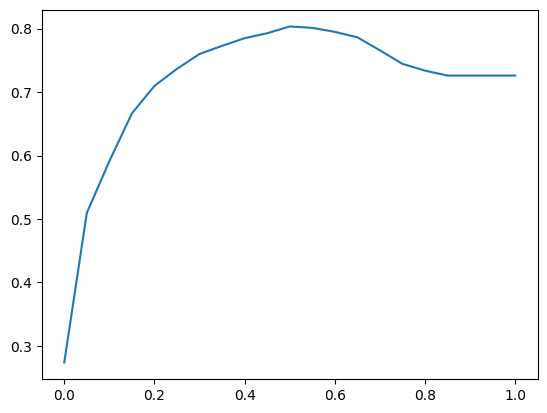

In [81]:
plt.plot(threshold, scores)

if we always predict churning t = 0 or always not churning t = 1  

In [88]:
from collections import Counter

In [90]:
Counter(y_pred >= 1.0) # only counted false values, so every customer predicted as not churning

Counter({False: 1409})

Why do we bother with our model, if when we predict all of them not churning we get 73% and with a model 80%?  
accuracy doesn' tell how good the model is, because there is more more not churning users than churning ones.  
72% not churning  
27% churning  
class imbalance

### Confusion Table

In [96]:
actual_postive = (y_val == 1)
actual_negative = (y_val == 0)

t = 0.5

pred_positive = y_pred >= t 
pred_negative = y_pred < t

In [105]:
tp = (pred_positive & actual_postive).sum()
tn = (pred_negative & actual_negative).sum()
fp = (pred_positive & actual_negative).sum()
fn = (pred_negative & actual_postive).sum()

In [108]:
confusion_matrix = np.array([[tn, fp],  [fn, fp]])
confusion_matrix

array([[922, 101],
       [176, 101]], dtype=int64)

 lot more false negative than false positive

In [116]:
from sklearn.metrics import confusion_matrix

In [118]:
a = confusion_matrix(y_val, y_pred>=0.5)

In [120]:
a/a.sum()

array([[0.6543648 , 0.07168204],
       [0.12491128, 0.14904187]])

### Precision and Recall

accuracy is (tp + tn) /(tp + tn + fp + fn)  
precision:  fraction of positive predictions that are correct  
tp / (tp + fp) 

In [126]:
p = tp/ (tp +fp) # only 65% of people we sent an email to, where actually going to churn
# 33% where a mistake.
# better than chance I guess

Recall fraction of correctly identified postive examples
tp / (tp + fn)

In [127]:
r = tp/ (tp+fn)
r

0.5440414507772021

failed to identify 46% of churning people  
for this purpose the accuracy is bad

In [128]:
# true positive rate 
tpr = tp / (tp + fn) # maximize it
fpr = fp / (fp+ tn) #minimize it
print(tpr, fpr)

0.5440414507772021 0.09872922776148582


### ROC Curves
reciever operator characteristic  
rate quality of soft predictions  
evalueate the 2 values for all possible thresholds

In [143]:
scores = [] 
threshold = np.linspace(0,1, 101)
for t in threshold:
    actual_postive = (y_val == 1)
    actual_negative = (y_val == 0)
    pred_positive = y_pred >= t 
    pred_negative = y_pred < t

    tp = (pred_positive & actual_postive).sum()
    tn = (pred_negative & actual_negative).sum()
    fp = (pred_positive & actual_negative).sum()
    fn = (pred_negative & actual_postive).sum()
    scores.append((t, tp, fp, fn, tn))

In [144]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns = columns)

In [151]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [153]:
df_scores[0:10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,385,908,1,115,0.997409,0.887586
2,0.02,384,828,2,195,0.994819,0.809384
3,0.03,383,766,3,257,0.992228,0.748778
4,0.04,381,715,5,308,0.987047,0.698925
5,0.05,379,684,7,339,0.981865,0.668622
6,0.06,377,660,9,363,0.976684,0.645161
7,0.07,371,641,15,382,0.961140,0.626588
8,0.08,371,612,15,411,0.961140,0.598240
9,0.09,369,581,17,442,0.955959,0.567937


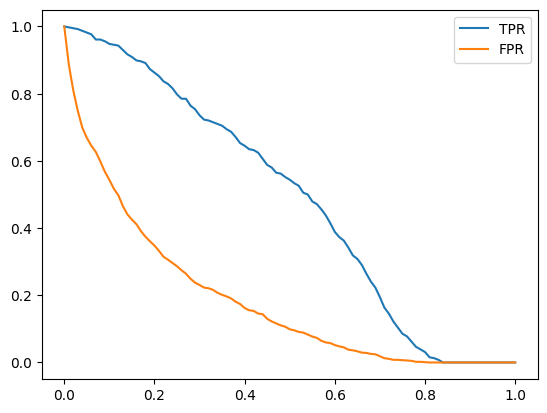

In [155]:
plt.plot(threshold,df_scores['tpr'], label='TPR')
plt.plot(threshold,df_scores['fpr'], label='FPR')
plt.legend()

### random model

In [156]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [158]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [164]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = [] 
    threshold = np.linspace(0,1, 101)
    
    for t in threshold:
        actual_postive = (y_val == 1)
        actual_negative = (y_val == 0)
        pred_positive = y_pred >= t 
        pred_negative = y_pred < t

        tp = (pred_positive & actual_postive).sum()
        tn = (pred_negative & actual_negative).sum()
        fp = (pred_positive & actual_negative).sum()
        fn = (pred_negative & actual_postive).sum()
        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns = columns)
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    return df_scores

In [167]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [168]:
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


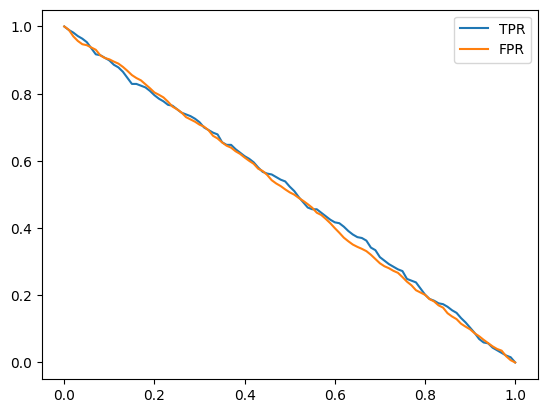

In [169]:
plt.plot(threshold,df_rand['tpr'], label='TPR')
plt.plot(threshold,df_rand['fpr'], label='FPR')
plt.legend()

### ideal model

In [172]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

y_ideal = np.repeat([0,1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [173]:
y_ideal_pred = np.linspace(0,1, len(y_val))

In [175]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [177]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

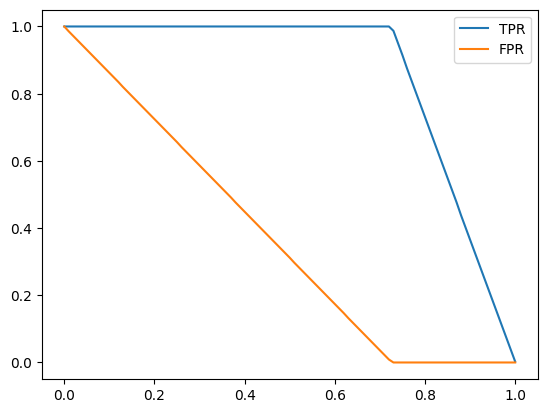

In [178]:
plt.plot(threshold,df_ideal['tpr'], label='TPR')
plt.plot(threshold,df_ideal['fpr'], label='FPR')
plt.legend()

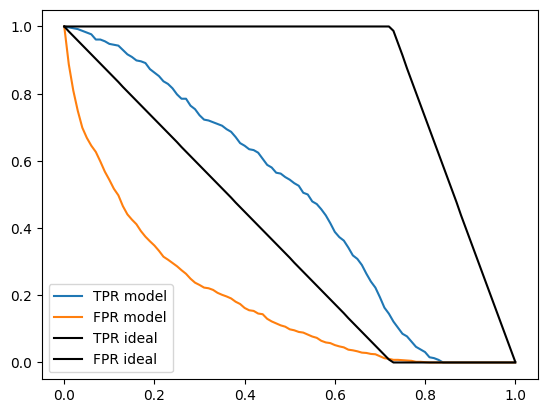

In [182]:
#plt.plot(threshold,df_rand['tpr'], label='TPR rand')
#plt.plot(threshold,df_rand['fpr'], label='FPR rand')

plt.plot(threshold,df_scores['tpr'], label='TPR model')
plt.plot(threshold,df_scores['fpr'], label='FPR model')


plt.plot(threshold,df_ideal['tpr'], label='TPR ideal', color = 'black')
plt.plot(threshold,df_ideal['fpr'], label='FPR ideal', color = 'black')
plt.legend()

tpr stays at 1 and goes down at threshold  bigger than 0.726 because values are classified as 0 even though they are 1, until all vlaues are classified as 0 and none as 1.  
if all of them are classified as 0 FPR is zero, cause none is positive.  
Only if value at threshold than model is ideal TPR = 1 and FPR is 0.

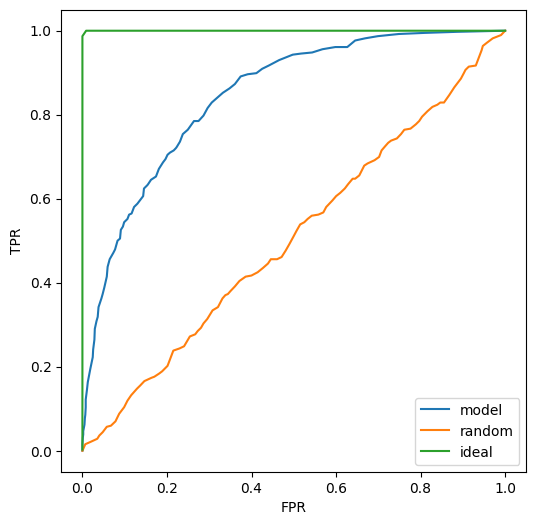

In [190]:
plt.figure(figsize=(6,6))
plt.plot(df_scores.fpr, df_scores.tpr, label ='model')
plt.plot(df_rand.fpr, df_rand.tpr, label ='random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label ='ideal')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

if there is a pint with 1 as ration so both are 100% then we have the perfect model.  
random is a line (winkelhalbierende)  
have a curve as close as possible to the ideal spot.  
this is the ROC curve.  
(0.0) is when threshold is 1 
and (1, 1) when threshold is 0.
if model goes below baseline, switch positive and negative predictions. It should not happen, you have a mistake.

In [191]:
from sklearn.metrics import roc_curve

In [197]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

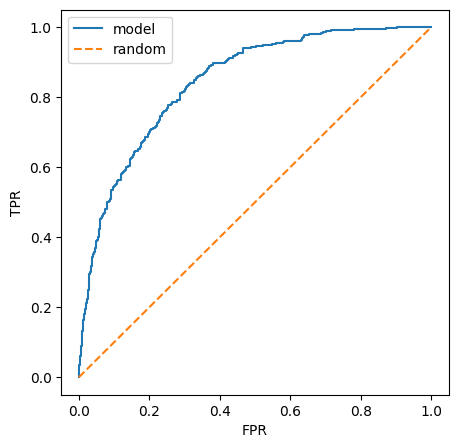

In [199]:
plt.figure(figsize=(5,5))

plt.plot(fpr, tpr, label ='model')
plt.plot([0, 1], [0,1], label ='random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

### ROC AUC 
Area under the ROC curve, tells how good the classifier is. 

In [201]:
# if area under the curve is high the model is better
# random = 0.5
# ideal AUC = 1.0
# poor performance 0.6, 0.8 good, 0.9 great

In [202]:
from sklearn.metrics import auc

In [203]:
auc(fpr,tpr)

0.8439720622572034

In [204]:
auc(df_scores.fpr, df_scores.tpr)

0.8435225563338551

In [206]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [ ]:
fpr_ideal, tpr_ideal, threshold_fpr = roc_curve(y_val, y_pred)
auc(df_scores.fpr, df_scores.tpr)

In [207]:
from sklearn.metrics import roc_auc_score

In [208]:
roc_auc_score(y_val, y_pred)

0.8439720622572034

the probability that a randomly selected postive example has a score higher than a randomly selected negative example.

In [209]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [210]:
neg

array([0.00892118, 0.2043846 , 0.21256982, ..., 0.11026155, 0.30935822,
       0.13560576])

In [211]:
pos

array([0.54255934, 0.57946369, 0.4615947 , 0.73838105, 0.06653434,
       0.69146914, 0.24689703, 0.69520848, 0.21243797, 0.6644207 ,
       0.47167118, 0.34793512, 0.15146008, 0.61567003, 0.7635762 ,
       0.14201031, 0.43346525, 0.27380052, 0.06741462, 0.19450635,
       0.66841724, 0.41808766, 0.66119925, 0.58147447, 0.52366119,
       0.43276893, 0.46688675, 0.35115493, 0.56894902, 0.32108667,
       0.6339473 , 0.74309126, 0.73738602, 0.60942182, 0.70701303,
       0.76387735, 0.10623855, 0.18002003, 0.53870322, 0.5780973 ,
       0.43600948, 0.44009487, 0.75609076, 0.38771831, 0.69327759,
       0.42061425, 0.75662635, 0.30225707, 0.53433509, 0.57856838,
       0.15546081, 0.52953961, 0.78493581, 0.43379815, 0.67273171,
       0.77323539, 0.0125094 , 0.35040659, 0.7965836 , 0.58560812,
       0.67356133, 0.24759012, 0.34507148, 0.7008843 , 0.21033806,
       0.68484123, 0.63553167, 0.29088877, 0.66014467, 0.30873688,
       0.49962613, 0.27281368, 0.39839552, 0.40946608, 0.50072

In [212]:
import random

### Cross Validation